In [28]:
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from PIL import Image

import os
import torch.nn as nn
import torch.optim as optim
import torch
import torchvision
import matplotlib.pyplot as plt

# Data Augmentation

In [37]:

# Ruta a la carpeta principal donde se encuentran las 2 clases
# Ejemplo: dataPractica/caltech101/101_ObjectCategories
ruta_base = '../dataPractica/caltech101/101_ObjectCategories'

# Lista de clases de interés
clases_de_interes = ['buddha', 'dalmatian']

# Definir cuántas versiones nuevas quieres crear por cada imagen original.
# Ajusta este número según la cantidad de imágenes finales que quieras.
# Por ejemplo:
# - 2 => duplicas (aprox.) tu dataset
# - 3 => triplicas, etc.
num_nuevas_por_imagen = 2

# Definimos las transformaciones de data augmentation que generan imágenes realistas 
# para buddha y dalmatian. Evitamos volteos verticales o rotaciones extremas.
transformaciones = transforms.Compose([
    # 1) Ajuste del tamaño a 256x256
    transforms.Resize((256, 256)),

    # 2) Recorte aleatorio para 224x224, simulando diferentes encuadres/zoom
    transforms.RandomResizedCrop(
        size=224,
        scale=(0.8, 1.0),       # rango de escalado
        ratio=(0.9, 1.1)        # rango de aspecto (ancho x alto)
    ),

    # 3) Rotación aleatoria moderada (±15 grados)
    transforms.RandomRotation(degrees=15),

    # 4) Flip horizontal aleatorio (probabilidad 0.5)
    transforms.RandomHorizontalFlip(p=1),

    # 5) Ajustes de color para simular distintas condiciones de iluminación
    transforms.ColorJitter(
        brightness=0.2, 
        contrast=0.2, 
        saturation=0.2, 
        hue=0.05
    ),

    transforms.ToTensor(),  # Convertir a tensor
    transforms.Normalize((0,), (1,))  # Normalización
])

num_buddhas_originales = 85
num_dalmatians_originales = 67

# ---- CREACIÓN DE NUEVAS IMÁGENES ----
for clase in clases_de_interes:
    # Carpeta de origen (donde están las imágenes originales)
    carpeta_origen = os.path.join(ruta_base, clase).replace('\\', '/')

    carpeta_destino = carpeta_origen
    os.makedirs(carpeta_destino, exist_ok=True)

    if clase == 'buddha':
        indice = num_buddhas_originales
    else:
        indice = num_dalmatians_originales

    # Listar las imágenes originales
    imagenes = [
        f for f in os.listdir(carpeta_origen)
        if os.path.isfile(os.path.join(carpeta_origen, f)) 
           and f.lower().endswith(('.png', '.jpg', '.jpeg'))
    ][:indice]

    print(f"\nClase: {clase}")
    print(f"  Imágenes originales: {len(imagenes)}")

    
    indice += 1
    # Generar nuevas imágenes
    contador_nuevas = 0
    for nombre_imagen in imagenes:
        ruta_imagen = os.path.join(carpeta_origen, nombre_imagen)

        # Abrir la imagen original en modo RGB
        imagen_original = Image.open(ruta_imagen).convert('RGB')

        # Crear 'num_nuevas_por_imagen' transformaciones diferentes
        for i in range(num_nuevas_por_imagen):
            # Aplicar transformaciones
            imagen_trans = transformaciones(imagen_original)

            # En caso de que la transformación devuelva un tensor, convertimos a PIL
            if isinstance(imagen_trans, torch.Tensor):
                imagen_trans = torchvision.transforms.ToPILImage()(imagen_trans)

            # Definir el nombre para la imagen aumentada
            nombre_sin_ext, ext = os.path.splitext(nombre_imagen)
            num_ceros = max(0, 4 - len(str(indice)))
            indice_formateado = f"{'0' * num_ceros}{indice}"
            nuevo_nombre = f"image_{indice_formateado}{ext}"

            # Guardar la imagen nueva en la carpeta destino
            ruta_salida = os.path.join(carpeta_destino, nuevo_nombre)
            imagen_trans.save(ruta_salida)

            indice += 1

    print(f"  Imágenes aumentadas generadas: {contador_nuevas}")
    print(f"  Guardadas en: {carpeta_destino}")
    



Clase: buddha
  Imágenes originales: 85
  Imágenes aumentadas generadas: 0
  Guardadas en: ../dataPractica/caltech101/101_ObjectCategories/buddha

Clase: dalmatian
  Imágenes originales: 67
  Imágenes aumentadas generadas: 0
  Guardadas en: ../dataPractica/caltech101/101_ObjectCategories/dalmatian


# Load Dataset

Tamaño del lote de imágenes: torch.Size([32, 3, 224, 224])
Etiquetas: tensor([1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0,
        1, 0, 1, 1, 0, 0, 0, 1])


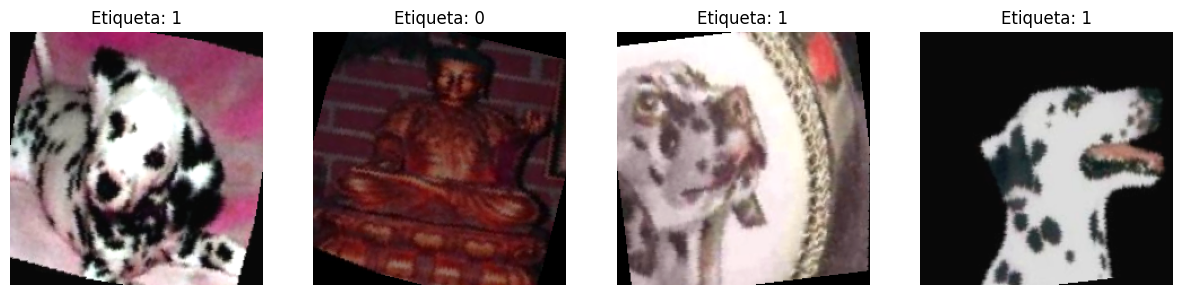

In [ ]:
# Cargar el dataset con ImageFolder
dataset = datasets.ImageFolder(
    root=ruta_base,
    transform=transformaciones
)

# Crear un DataLoader para cargar los datos en lotes
data_loader = DataLoader(dataset, batch_size=32, shuffle=True)

# Probar el dataset cargando un lote
for images, labels in data_loader:
    print(f"Tamaño del lote de imágenes: {images.shape}")
    print(f"Etiquetas: {labels}")
    
    # Mostrar las imágenes del lote
    fig, axes = plt.subplots(1, 4, figsize=(15, 15))  # Más espacio para cada imagen
    for i, img in enumerate(images):
        img = transforms.ToPILImage()(img)  # Convertir el tensor a imagen PIL
        axes[i].imshow(img, interpolation='bilinear')  # Mejor interpolación
        axes[i].set_title(f"Etiqueta: {labels[i].item()}")
        axes[i].axis("off")
    plt.tight_layout()  # Ajustar los espacios en el plot
    plt.show()
    break  # Salir después de mostrar un lote

# Clasificación de imágenes

## ALexNet

In [ ]:
# Cargar el modelo AlexNet preentrenado
alexNet = models.alexnet(pretrained=True)

# Congelar todos los parámetros para el Fine Tuning
for param in alexNet.parameters():
    param.requires_grad = False

alexNet.classifier = nn.Sequential(
    nn.Linear(alexNet.classifier[1].in_features, 1024),
    nn.ReLU(),
    nn.Linear(1024, 1024),
    nn.ReLU(),
    nn.Linear(1024, 256),
    nn.ReLU(),
    nn.Linear(256, len(clases_de_interes)),
    nn.Softmax(dim=1)
)

# Definir el criterio (función de pérdida) y el optimizador
loss_fn = nn.CrossEntropyLoss()
learning_rate = 1e-3  # Hiperparàmetre
optimizer = optim.Adam(alexNet.parameters(), lr=learning_rate)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = alexNet.to(device)

running_loss = []
running_acc = []

running_test_loss = []
running_test_acc = []

In [ ]:
for t in tqdm(range(EPOCHS), desc="Èpoques"):
    batch_loss = 0
    batch_acc = 0
    
    i_batch = 1
    # Iteram els batches.
    for i_batch, (x, y) in tqdm(enumerate(train_loader), desc=f"Batches (Època {t + 1})"):
        alexNet.train()  # Posam el model a mode entranament.

        optimizer.zero_grad()

        # 1. PREDICCIÓ

        y_pred = alexNet(x.to(device))

        # 2. CALCUL DE LA PÈRDUA
        # Computa la pèrdua: l'error de predicció vs el valor correcte
        # Es guarda la pèrdua en un array per futures visualitzacions

        loss = loss_fn(y_pred, y.to(device))

        #3. GRADIENT
        alexNet.zero_grad()
        loss.backward()

        # Actualitza els pesos utilitzant l'algorisme d'actualització
        #4. OPTIMITZACIO
        with torch.no_grad():
            optimizer.step()

        # 5. EVALUAM EL MODEL
        alexNet.eval()  # Mode avaluació de la xarxa

        y_pred = alexNet(x.to(device))
        batch_loss += (loss_fn(y_pred, y.to(device)).detach())

        y_pred_class = torch.argmax(y_pred, dim=1).detach().cpu().numpy()
        batch_acc += accuracy_score(y.cpu().numpy(), y_pred_class)


    running_loss.append(batch_loss / (i_batch + 1))
    running_acc.append(batch_acc / (i_batch + 1))

    batch_test_loss = 0
    batch_test_acc = 0

    alexNet.eval()
    for i_batch, (x, y) in enumerate(test_loader):

        y_pred = alexNet(x.to(device))
        batch_test_loss += (loss_fn(y_pred, y.to(device)).detach())
        y_pred_class = torch.argmax(y_pred, dim=1).detach().cpu().numpy()
        acc = accuracy_score(y.cpu().numpy(), y_pred_class)
        batch_test_acc += acc

    running_test_loss.append(batch_test_loss / (i_batch + 1))
    running_test_acc.append(batch_test_acc / (i_batch + 1))